<a href="https://colab.research.google.com/github/Viddesh1/TCS_Sem_3_IA1_IA2/blob/main/TCS_Sem-3/IA_2/2_minimal_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Question :-

# In this assignment candidate will be able to create a model that can detect coronavirus patients
# from X-ray reports

In [2]:
# Installing kaggle using pip in quite mode

!pip install -q kaggle

# Mounting the google drive and uploading the kaggle API downloaded from kaggle account.

from google.colab import files, drive

files.upload() # Upload kaggle API here
drive.mount("/content/drive")

# Create a folder to store kaggle dataset on colab

!mkdir -p ~/.kaggle # Creating a directory
!cp kaggle.json ~/.kaggle/ # Copying the kaggle.json API key file to .kaggle directory
!chmod 600 /root/.kaggle/kaggle.json # Giving appropriate permision

# Downloading the datset from kaggle datset API.
# Below is the datset link:-
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

!kaggle datasets download -d pranavraikokte/covid19-image-dataset

# Unzipping the zip file

!unzip /content/covid19-image-dataset.zip

Saving kaggle.json to kaggle.json
Mounted at /content/drive
100% 158M/158M [00:01<00:00, 143MB/s]
100% 158M/158M [00:01<00:00, 127MB/s]
Archive:  /content/covid19-image-dataset.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-000

In [21]:
# Importing all the necessary libraries
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import sys


import tensorflow
import matplotlib
import sklearn
import seaborn

print(f"cv2 version :- {cv2.__version__}")
print(f"tensorflow version :- {tensorflow.__version__}")
print(f"matplotlib version :- {matplotlib.__version__}")
print(f"sklearn version :- {sklearn.__version__}")
print(f"seaborn version :- {seaborn.__version__}")
# Get the Python version
print("Python version:", sys.version.split(" ")[0])

cv2 version :- 4.8.0
tensorflow version :- 2.13.0
matplotlib version :- 3.7.1
sklearn version :- 1.2.2
seaborn version :- 0.12.2
Python version: 3.10.12


In [4]:
os.getcwd() # Current working directory

'/content'

In [5]:
# Creating a directory for outputs

!mkdir -p "/content/drive/MyDrive/TCS_Sem3_IA2_output"

In [6]:
# Saving the path of the train directory and test directory as string.

train_dir_path = "/content/Covid19-dataset/train"
test_dir_path = "/content/Covid19-dataset/test"

In [7]:
image_height = 224
image_width = 224
batch_size = 32

In [8]:
X_train = []

for folder in os.listdir(train_dir_path):
    sub_path = train_dir_path + "/" + folder
    for image in os.listdir(sub_path):
        image_train = sub_path + "/" + image
        image = cv2.imread(image_train)
        image = cv2.resize(image, (image_height, image_width)) # ResNet-50 needs an input shape of 224 x 224
        X_train.append(image)

In [9]:
X_test = []

for folder in os.listdir(test_dir_path):
    sub_test = test_dir_path + "/" + folder
    for image in os.listdir(sub_test):
        image_test = sub_test + "/" + image
        image = cv2.imread(image_test)
        image = cv2.resize(image, (image_height, image_width))
        X_test.append(image)

In [10]:
print("Maximum value of the first image in X_train: ", float(np.max(X_train[0])))
print("Minumum value of the first image in X_train: ", float(np.min(X_train[0])))

print("Maximum value of the first value in X_test: ", float(np.max(X_test[0])))
print("Minimum value of the first image in X_test: ", float(np.min(X_test[0])))

Maximum value of the first image in X_train:  255.0
Minumum value of the first image in X_train:  0.0
Maximum value of the first value in X_test:  249.0
Minimum value of the first image in X_test:  30.0


In [11]:
# Preprocessing the x_train and x_test

# train = np.array(X_train) / 255.0
# test = np.array(X_test) / 255.0

In [12]:
train_data = ImageDataGenerator(rescale = 1.0 / 255.0, validation_split = 0.2)
test_data = ImageDataGenerator(rescale = 1.0 / 255.0)

In [13]:
train_set = train_data.flow_from_directory(
    train_dir_path,
    subset = "training",
    batch_size = batch_size,
    target_size = (image_height, image_width),
    class_mode = "categorical" # sparse
)
validation_set = train_data.flow_from_directory(
    train_dir_path,
    subset = "validation",
    batch_size = batch_size,
    target_size = (image_height, image_width),
    class_mode = "categorical" # sparse
)
test_set = test_data.flow_from_directory(
    test_dir_path,
    batch_size = batch_size,
    target_size = (image_height, image_width),
    class_mode = "categorical" # sparse
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [14]:
print(f" { len(test_set.classes) } Number images belonging to { len(test_set.class_indices) } classes in test data set. ")
print(f" { len(train_set.classes) } Number of images belonging to { len(train_set.classes) } classes in train data set. ")
print(f" { len(validation_set.classes) } Number of images belonging to { len(validation_set.classes) } classes in validation data set. ")

 66 Number images belonging to 3 classes in test data set. 
 201 Number of images belonging to 201 classes in train data set. 
 50 Number of images belonging to 50 classes in validation data set. 


In [15]:
print(train_set.class_indices)
print(test_set.class_indices)
print(validation_set.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [16]:
y_train = train_set.classes
y_validation = validation_set.classes
y_test = test_set.classes

print("y_train :-", y_train, end = "\n\n")
print("y_val :- ", y_validation, end = "\n\n")
print("y_test :- ", y_test)

y_train :- [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

y_val :-  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]

y_test :-  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


<ipython-input-17-bead4766150d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i + 1)


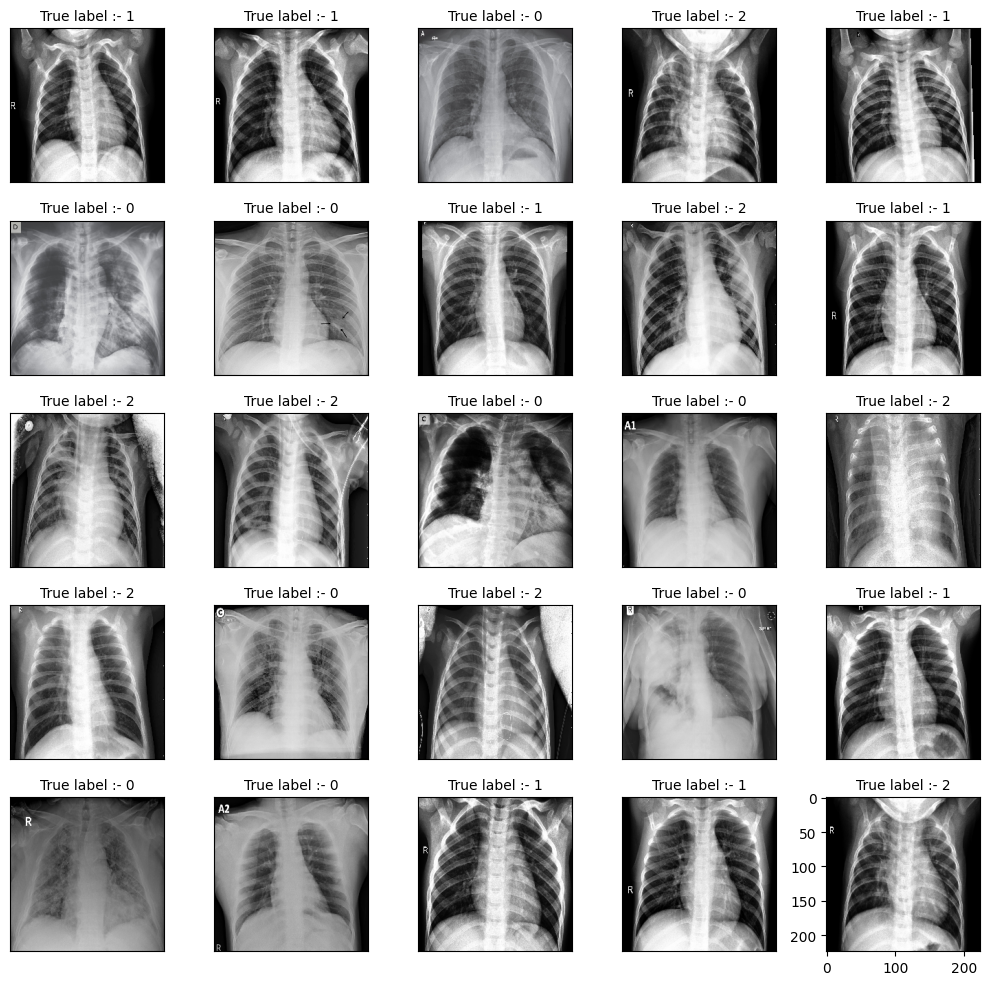

In [17]:
# Get a batch of images and labels from the test_set
batch_images, batch_one_hot_labels  = next(test_set)

# Convert one-hot encoded labels to integer labels
batch_labels = np.argmax(batch_one_hot_labels, axis=1)

# Display the images and labels
plt.figure(figsize = (10, 10))
for i in range(0, 25, 1):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"True label :- {batch_labels[i]}", fontsize = 10)

plt.tight_layout()
plt.show()

In [18]:
# ResNet50 Model Transer Learning

resnet_50 = ResNet50(
    include_top = False,
    input_shape = (224, 224, 3),
    weights = "imagenet"
    )

for layers in resnet_50.layers:
    layers.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [19]:
# Early Stopping

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True,
    min_delta = 0.001,
    verbose = 0
)

In [23]:
# Is facing some erro in this cell then just run imports again.

resnet_50_model_1 = Sequential(
    [
        layers.RandomFlip(mode = "horizontal"),
        layers.RandomRotation(factor = 0.2),
        resnet_50,
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units = 512, activation = "relu"),
        layers.Dense(units = 100, activation = "relu"),
        layers.Dense(units = 3, activation = "softmax")
    ]
)

In [24]:
resnet_50_model_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy", # sparse_categorical_crossentropy
    metrics = ["accuracy"]
)

In [25]:
# Fitting the ResNet-50 model

training_resnet_50_model_1 = resnet_50_model_1.fit(
    train_set,
    callbacks = [early_stopping],
    steps_per_epoch = 7,
    epochs = 10, # 100
    validation_data = validation_set
)

Epoch 1/10
7/7 [==============================] - 15s 1s/step - loss: 1.1662 - accuracy: 0.3731 - val_loss: 1.0083 - val_accuracy: 0.5200
Epoch 2/10
7/7 [==============================] - 5s 692ms/step - loss: 1.0806 - accuracy: 0.4279 - val_loss: 1.0544 - val_accuracy: 0.2600
Epoch 3/10
7/7 [==============================] - 7s 1s/step - loss: 0.9880 - accuracy: 0.4975 - val_loss: 1.0538 - val_accuracy: 0.3600
Epoch 4/10
7/7 [==============================] - 5s 747ms/step - loss: 0.9966 - accuracy: 0.4826 - val_loss: 0.8785 - val_accuracy: 0.6000
Epoch 5/10
7/7 [==============================] - 6s 846ms/step - loss: 0.9207 - accuracy: 0.5920 - val_loss: 0.8737 - val_accuracy: 0.5600
Epoch 6/10
7/7 [==============================] - 6s 939ms/step - loss: 0.8553 - accuracy: 0.6020 - val_loss: 0.8672 - val_accuracy: 0.6000
Epoch 7/10
7/7 [==============================] - 6s 879ms/step - loss: 0.8211 - accuracy: 0.5871 - val_loss: 0.8618 - val_accuracy: 0.5800
Epoch 8/10
7/7 [=========

In [26]:
# Saving the ResNet-50 model after training

resnet_50_model_1.save("/content/drive/MyDrive/TCS_Sem3_IA2_output/Resnet_50_model.keras")

In [27]:
# Loading the entire model (Architecture and weights) from current directory
resnet_50_model_1 = load_model("/content/drive/MyDrive/TCS_Sem3_IA2_output/Resnet_50_model.keras")

In [28]:
# Evaluate the model on the test data set

loss, accuracy = resnet_50_model_1.evaluate(test_set, verbose = 0)

# Evaluation result
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)

Test loss:  0.7314067482948303
Test accuracy:  0.6515151262283325


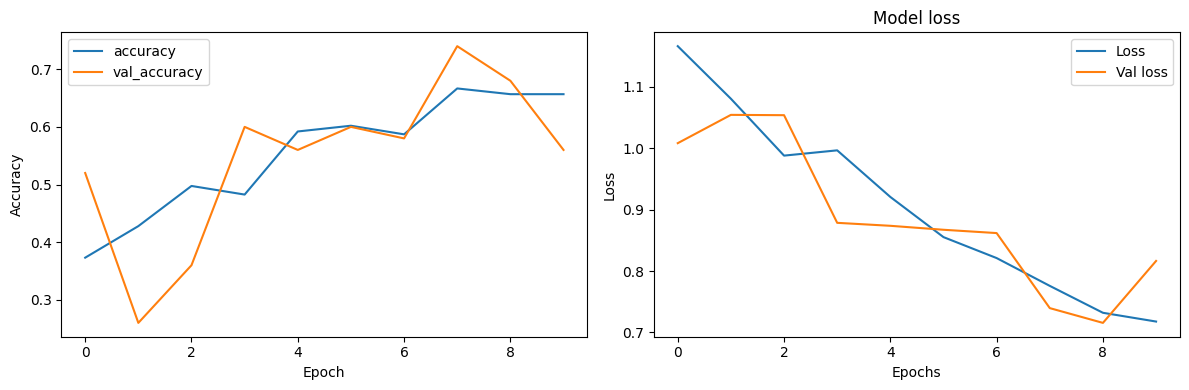

In [46]:
# Plotting the Training loss and Validation Loss and Training Accuracy and Validation Accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot of model accuracy
ax1.plot(training_resnet_50_model_1.history["accuracy"], label="accuracy")
ax1.plot(training_resnet_50_model_1.history["val_accuracy"], label="val_accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="upper left")

# Plot for model loss
ax2.plot(training_resnet_50_model_1.history["loss"], label="Loss")
ax2.plot(training_resnet_50_model_1.history["val_loss"], label="Val loss")
ax2.set_title("Model loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Loss", "Val loss"], loc='upper right')

plt.savefig("/content/drive/MyDrive/TCS_Sem3_IA2_output/Resnet50_Accuracy_Loss.png")

# Adjust layout for better spacing between subplots
plt.tight_layout()

plt.show()


In [30]:
# Making prediction of resnet_50_model

predicted = resnet_50_model_1.predict(test_set)
final_predictions = np.argmax(predicted, axis = 1)
final_predictions

3/3 [==============================] - 2s 288ms/step


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0])

1/1 [==============================] - 1s 967ms/step


<ipython-input-31-720e81d03cfd>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i + 1)


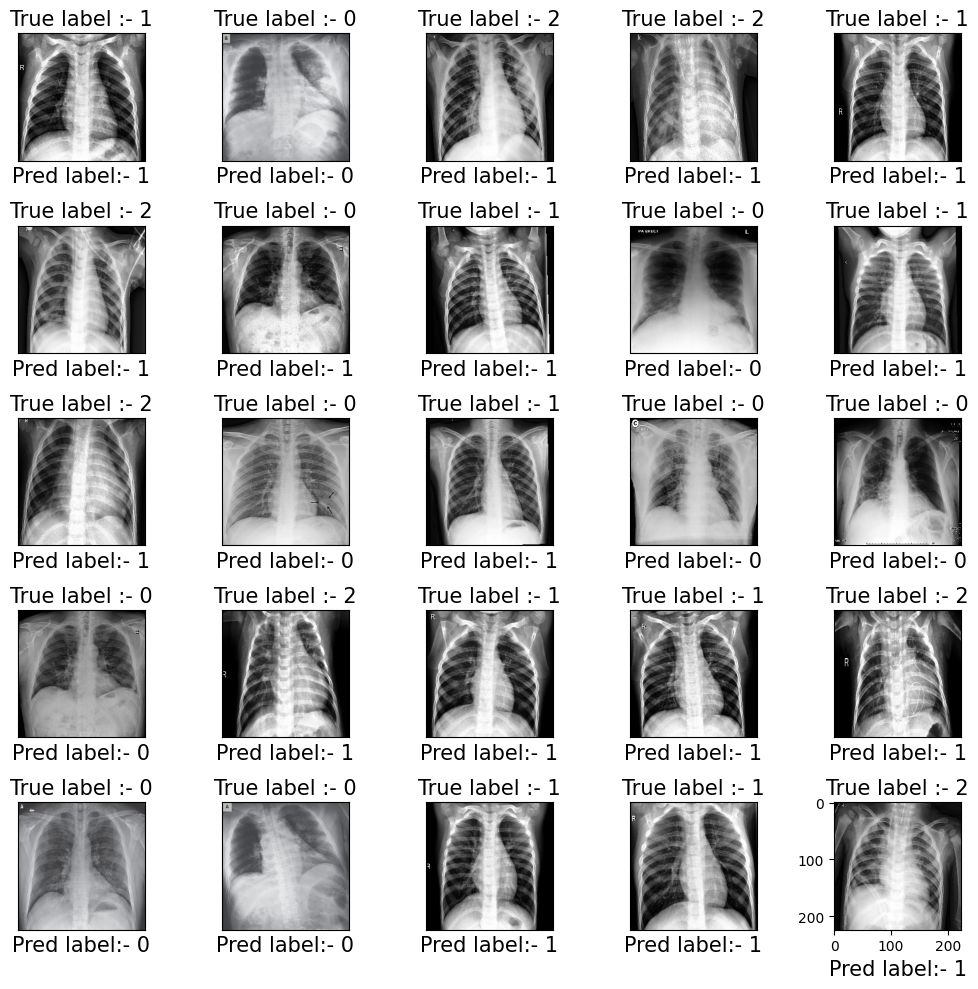

In [31]:
# Get a batch of images and true labels from the test_set
batch_images, true_labels = next(test_set)
true_labels = true_labels.argmax(axis=1)  # Convert one-hot encoded labels to integer labels

# Model prediction
predictions = resnet_50_model_1.predict(batch_images)
predicted_labels = np.argmax(predictions, axis=1)


plt.figure(figsize = (10, 10))
for i in range(0, 25, 1):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"True label :- {true_labels[i]}", fontsize = 15)
    plt.xlabel(f"Pred label:- {predicted_labels[i]}", fontsize = 15)

plt.tight_layout()
plt.show()

In [32]:
# Creating custom model 2

model_2 = Sequential(
    [
        layers.Conv2D(input_shape = (224, 224, 3), filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "valid", data_format = None,
            dilation_rate = (1, 1), groups = 1, activation = "relu", use_bias = True,
            kernel_initializer = "glorot_uniform", bias_initializer = "zeros",
            kernel_regularizer = None, bias_regularizer = None, activity_regularizer = None,
            kernel_constraint = None, bias_constraint = None),
        layers.MaxPooling2D(pool_size = (2, 2), strides = None, padding = "valid", data_format = None),
        layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "valid", data_format = None),
        layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid", data_format = None),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(units = 3, activation = "softmax", use_bias = True, kernel_initializer = "glorot_uniform",
        bias_initializer = "zeros", kernel_regularizer = None, bias_regularizer = None,
        activity_regularizer = None, kernel_constraint = None, bias_constraint = None)
    ]
)

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 108, 108, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 373248)            0         
                                                                 
 dropout (Dropout)           (None, 373248)           

In [33]:
model_2.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [34]:
training_2 = model_2.fit(
    train_set,
    callbacks = [early_stopping],
    steps_per_epoch = 7,
    epochs = 10,
    validation_data = validation_set
)

Epoch 1/10
7/7 [==============================] - 9s 905ms/step - loss: 13.4827 - accuracy: 0.3980 - val_loss: 4.4676 - val_accuracy: 0.2800
Epoch 2/10
7/7 [==============================] - 4s 661ms/step - loss: 2.1266 - accuracy: 0.6070 - val_loss: 2.5015 - val_accuracy: 0.4200
Epoch 3/10
7/7 [==============================] - 4s 669ms/step - loss: 0.9066 - accuracy: 0.7711 - val_loss: 1.0542 - val_accuracy: 0.6800
Epoch 4/10
7/7 [==============================] - 5s 787ms/step - loss: 0.5159 - accuracy: 0.8408 - val_loss: 0.6067 - val_accuracy: 0.8000
Epoch 5/10
7/7 [==============================] - 6s 886ms/step - loss: 0.1856 - accuracy: 0.9204 - val_loss: 0.2809 - val_accuracy: 0.9000
Epoch 6/10
7/7 [==============================] - 5s 682ms/step - loss: 0.1266 - accuracy: 0.9602 - val_loss: 0.3311 - val_accuracy: 0.9200
Epoch 7/10
7/7 [==============================] - 4s 662ms/step - loss: 0.0827 - accuracy: 0.9652 - val_loss: 0.2920 - val_accuracy: 0.9400
Epoch 8/10
7/7 [===

In [36]:
# Saving the Custome model
model_2.save("/content/drive/MyDrive/TCS_Sem3_IA2_output/Custom_model.keras")

# Loading the saved custome model
model_2 = load_model("/content/drive/MyDrive/TCS_Sem3_IA2_output/Custom_model.keras")

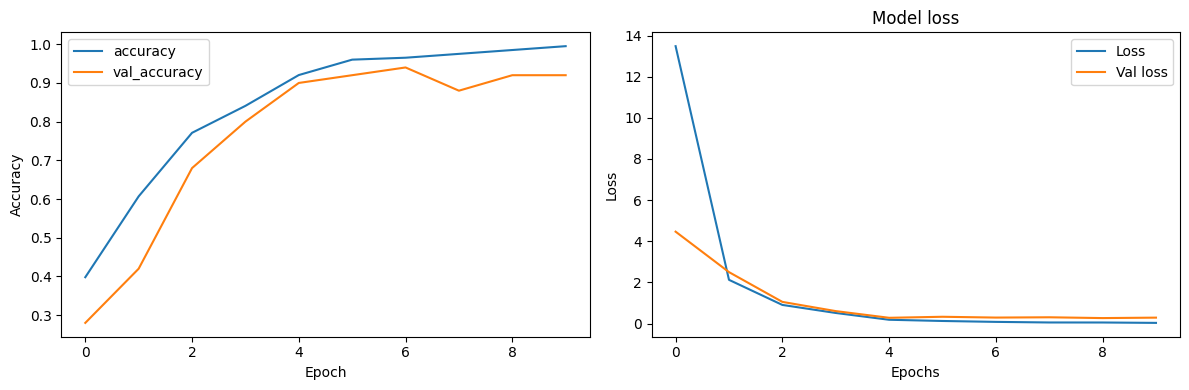

In [47]:
# Plotting the Training loss and Validation Loss and Training Accuracy and Validation Accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot of model accuracy
ax1.plot(training_2.history["accuracy"], label="accuracy")
ax1.plot(training_2.history["val_accuracy"], label="val_accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="upper left")

# Plot for model loss
ax2.plot(training_2.history["loss"], label="Loss")
ax2.plot(training_2.history["val_loss"], label="Val loss")
ax2.set_title("Model loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Loss", "Val loss"], loc='upper right')

plt.savefig("/content/drive/MyDrive/TCS_Sem3_IA2_output/Custom_model_Accuracy_Loss.png")

# Adjust layout for better spacing between subplots
plt.tight_layout()

plt.show()


1/1 [==============================] - 0s 38ms/step


<ipython-input-40-486a3a8e4229>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i + 1)


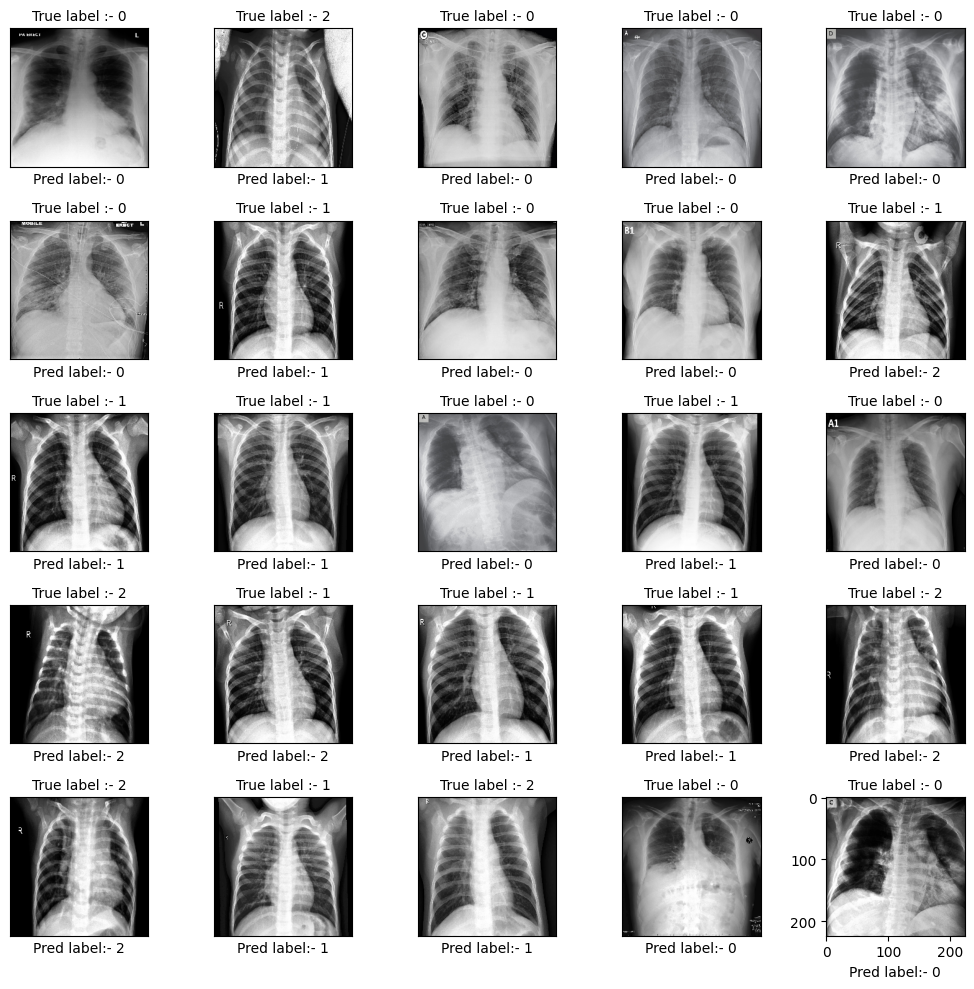

In [40]:
# Run the cell again if there is any error
# Get a batch of images and true labels from the test_set
batch_images, true_labels = next(test_set)
true_labels = true_labels.argmax(axis=1)  # Convert one-hot encoded labels to integer labels

# Model prediction
predictions = model_2.predict(batch_images)
predicted_labels = np.argmax(predictions, axis=1)


plt.figure(figsize = (10, 10))
for i in range(0, 25, 1):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"True label :- {true_labels[i]}", fontsize = 10)
    plt.xlabel(f"Pred label:- {predicted_labels[i]}", fontsize = 10)

plt.tight_layout()
plt.show()

In [41]:
# Evaluate the model on the test data set

loss, accuracy = resnet_50_model_1.evaluate(test_set, verbose = 0)

# Evaluation result
print("ResNet-50 Test loss: ", loss)
print("ResNet-50 Test accuracy: ", accuracy)

loss, accuracy = model_2.evaluate(test_set, verbose = 0)

# Evaluation result
print("Custom model 1 Test loss: ", loss)
print("Custom model 1 Test accuracy: ", accuracy)

ResNet-50 Test loss:  0.7314068078994751
ResNet-50 Test accuracy:  0.6515151262283325
Custom model 1 Test loss:  0.32181107997894287
Custom model 1 Test accuracy:  0.8484848737716675


In [42]:
# Generate the predictions from the resnet-50 model
predictions = resnet_50_model_1.predict(test_set)

# Convert the prediction probabilities to class labels
predicted_labels = np.argmax(predictions, axis = 1)

# Getting the true labels from the test generator
true_labels = test_set.classes

# Classification repor calculations
print("Classification Report Resnet-50:- ")
report = classification_report(true_labels, predicted_labels, target_names = test_set.class_indices.keys(), zero_division = 0)
print(report)

3/3 [==============================] - 1s 199ms/step
Classification Report Resnet-50:- 
                 precision    recall  f1-score   support

          Covid       0.33      0.31      0.32        26
         Normal       0.21      0.45      0.29        20
Viral Pneumonia       0.00      0.00      0.00        20

       accuracy                           0.26        66
      macro avg       0.18      0.25      0.20        66
   weighted avg       0.20      0.26      0.21        66



In [43]:
# Generate the predictions from the custom model 2
predictions = model_2.predict(test_set)

# Convert the prediction probabilities to class labels
predicted_labels = np.argmax(predictions, axis = 1)

# Getting the true labels from the test generator
true_labels = test_set.classes

# Classification repor calculations
print("Classification Report of custom model 2:- ")
report = classification_report(true_labels, predicted_labels, target_names = test_set.class_indices.keys(), zero_division = 0)
print(report)

3/3 [==============================] - 1s 147ms/step
Classification Report of custom model 2:- 
                 precision    recall  f1-score   support

          Covid       0.44      0.42      0.43        26
         Normal       0.38      0.40      0.39        20
Viral Pneumonia       0.30      0.30      0.30        20

       accuracy                           0.38        66
      macro avg       0.37      0.37      0.37        66
   weighted avg       0.38      0.38      0.38        66



3/3 [==============================] - 1s 191ms/step


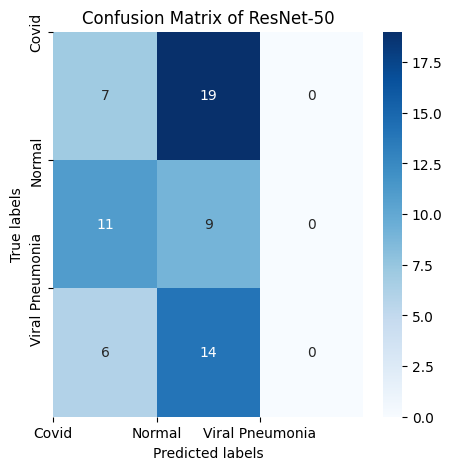

In [44]:
# Generate the predictions from the resnet-50 model
predictions = resnet_50_model_1.predict(test_set)

# Convert the prediction probabilities to class labels
predicted_labels = np.argmax(predictions, axis = 1)

# Getting the true labels from the test generator
true_labels = test_set.classes
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize = (5, 5))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap ="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix of ResNet-50")
plt.xticks(ticks = np.arange(len(test_set.class_indices)), labels = test_set.class_indices.keys())
plt.yticks(ticks = np.arange(len(test_set.class_indices)), labels = test_set.class_indices.keys())
plt.show()

3/3 [==============================] - 1s 144ms/step


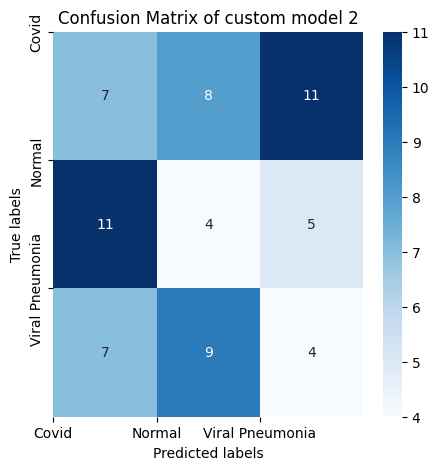

In [45]:
# Generate the predictions from the custom model 2
predictions = model_2.predict(test_set)

# Convert the prediction probabilities to class labels
predicted_labels = np.argmax(predictions, axis = 1)

# Getting the true labels from the test generator
true_labels = test_set.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize = (5, 5))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap ="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix of custom model 2")
plt.xticks(ticks = np.arange(len(test_set.class_indices)), labels = test_set.class_indices.keys())
plt.yticks(ticks = np.arange(len(test_set.class_indices)), labels = test_set.class_indices.keys())
plt.show()